In [557]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm_notebook
import time

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

from diffNN import *
from BlackScholes import *

import sys
sys.path.insert(0, '/Users/tk/Documents/GitHub/Speciale/rBergomi')
from rBergomi import roughBergomi

tf.executing_eagerly()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

In [558]:
layers = 4
units = 20

size = 2 ** 17
n_epochs = 100 
batch_size = int(max(256, size // 16))
custom_training = False

type = 'European' # Options: 'Cliquet', 'Asian', 'European', 'BlackScholes'

T = 1 
H = 0.1
eta = 1
rho = -0.3
xi = 0.235**2
spot = 100
strike = 110

In [559]:
if type == 'Asian':
    rB = roughBergomi(n_paths = size, n_steps = 52, T=T,
                        H=H, eta=eta, rho=rho, xi=xi, spot=spot, strike=strike)
    volterra, W, dW = rB.simulate_paths()
    V = rB.simulate_V(volterra)

    xTrain, yTrain, dydxTrain = rB.asian_payoff(V, dW)
    x_mean, x_std, x, y_mean, y_std, y, dydx, lambd = normalize_data(xTrain, yTrain, dydxTrain)
    xTest, yTest, dydxTest = rB.asian_test(V, dW, lower=35, upper=165)
    dydx = dydx.astype(np.float32)

if type == 'European':
    rB = roughBergomi(n_paths = size, n_steps = 52, T=T,
                        H=H, eta=eta, rho=rho, xi=xi, spot=spot, strike=strike)
    volterra, W, dW = rB.simulate_paths()
    V = rB.simulate_V(volterra)

    xTrain, yTrain, dydxTrain = rB.payoff_delta(V, dW)
    x_mean, x_std, x, y_mean, y_std, y, dydx, lambd = normalize_data(xTrain, yTrain, dydxTrain)
    xTest, yTest, dydxTest = rB.test(V, dW, lower=35, upper=165)
    dydx = dydx.astype(np.float32)

if type == 'BlackScholes':
    bs = BlackScholes()
    xTrain, yTrain, dydxTrain = bs.trainingSet(size)
    x_mean, x_std, x, y_mean, y_std, y, dydx, lambd = normalize_data(xTrain, yTrain, dydxTrain)
    xTest, yTest, dydxTest = bs.testSet(num=100)
    x = x.astype(np.float32)
    y = y.astype(np.float32)
    dydx = dydx.astype(np.float32)

if type == 'Cliquet':
    rB = roughBergomi(n_paths = size, n_steps = 52, T=T,
                        H=H, eta=eta, rho=rho, xi=xi, spot=spot, strike=strike)
    volterra, W, dW = rB.simulate_paths()
    V = rB.simulate_V(volterra)

    xTrain, yTrain, dydxTrain = rB.cliquet_payoff(V, dW, floor = -0.01, cap = 0.01, minmin = 0, minmax = 0.15, spot = 1.0)
    x_mean, x_std, x, y_mean, y_std, y, dydx, lambd = normalize_data(xTrain, yTrain, dydxTrain)
    xTest, yTest, dydxTest = rB.cliquet_test(V, dW, floor = -0.01, cap = 0.01, lower=0.0, upper=0.15)
    dydx = dydx.astype(np.float32)

if type == None:
    pass

Simulating training set:   0%|          | 0/131072 [00:00<?, ?it/s]

Simulating test set:   0%|          | 0/100 [00:00<?, ?it/s]

In [560]:
nn = create_graph(layers=layers, units=units)

if custom_training:

    training_set = tf.data.Dataset.from_tensor_slices((x,y,dydx))
    training_set = training_set.batch(batch_size)

    for epoch in tqdm_notebook(range(n_epochs), desc = 'Training differential network'):

        lr = lr_scheduler(epoch, n_epochs)
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

        for step, (x_batch, y_batch, dydx_batch) in enumerate(training_set):

            with tf.GradientTape() as tape:
                yhat_batch, dydxhat_batch = nn(x_batch, training = True)
                loss_value = differential_mse(y_batch, yhat_batch, dydx_batch, dydxhat_batch, lambd)

            grads = tape.gradient(loss_value, nn.trainable_weights)
            optimizer.apply_gradients(zip(grads, nn.trainable_weights))

else:

    optimizer = tf.keras.optimizers.Adam(learning_rate=LRSchedule(n_epochs, size, batch_size))
    nn.compile(loss=['mse', create_derivsLoss(lambd)], optimizer=optimizer, run_eagerly = True)

    print('Training differential neural network... ')
    t0 = time.time()
    history = nn.fit(
        x, [y, dydx], epochs=n_epochs, batch_size = batch_size, verbose = 1
    )
    t1 = time.time()
    print('Training completed in {} seconds'.format(round(t1-t0, 2)))

Training differential neural network... 
Epoch 1/100
16/16 [==============================] - 1s 36ms/step - loss: 3.5421 - output_loss: 2.5584 - derivs_loss: 0.9837
Epoch 2/100
16/16 [==============================] - 1s 32ms/step - loss: 1.9866 - output_loss: 1.0350 - derivs_loss: 0.9516
Epoch 3/100
16/16 [==============================] - 1s 32ms/step - loss: 1.6586 - output_loss: 0.8420 - derivs_loss: 0.8166
Epoch 4/100
16/16 [==============================] - 0s 31ms/step - loss: 1.1244 - output_loss: 0.5374 - derivs_loss: 0.5870
Epoch 5/100
16/16 [==============================] - 1s 31ms/step - loss: 0.9359 - output_loss: 0.4719 - derivs_loss: 0.4640
Epoch 6/100
16/16 [==============================] - 1s 31ms/step - loss: 0.8972 - output_loss: 0.4612 - derivs_loss: 0.4361
Epoch 7/100
16/16 [==============================] - 1s 31ms/step - loss: 0.8807 - output_loss: 0.4559 - derivs_loss: 0.4248
Epoch 8/100
16/16 [==============================] - 1s 32ms/step - loss: 0.8723 - o

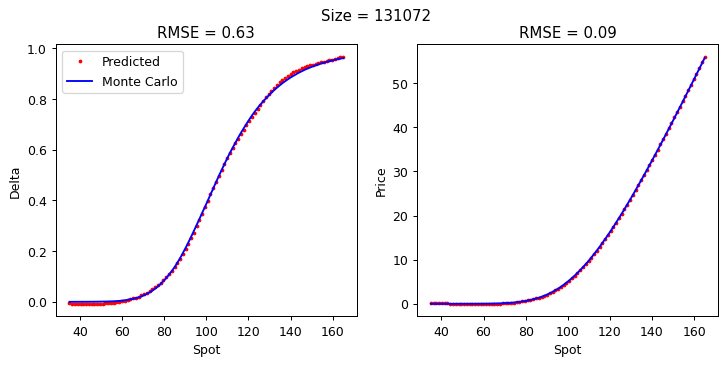

In [561]:
x_scaled = (xTest - x_mean) / x_std
y_scaled, dydx_scaled = nn.predict(x_scaled)
yPred = y_mean + y_std * y_scaled
dydxPred = y_std / x_std * dydx_scaled

plot_value_delta(xTest, yPred, yTest, dydxPred, dydxTest, size)